# TabM增强版：性早熟预测模型

**使用TabM进行全方位优化**

- 基础TabM模型（PiecewiseLinearEmbeddings）
- 超参数优化（Optuna HPO）
- 不同架构变体（tabm / tabm-mini）
- 独立批次训练策略
- 不同数值嵌入方式对比

## 1. 导入必要的库

In [11]:
import os
import math
import random
from copy import deepcopy

import pandas as pd
import numpy as np
import warnings
import joblib

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# TabM相关库
import tabm
import rtdl_num_embeddings
import torch
import torch.nn as nn
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

print(f"TabM版本: {tabm.__version__ if hasattr(tabm, '__version__') else 'N/A'}")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU设备: {torch.cuda.get_device_name(0)}")
print("所有库导入完成")

TabM版本: 0.0.3
PyTorch版本: 2.9.1+cu130
CUDA可用: True
GPU设备: NVIDIA GeForce RTX 3080 Laptop GPU
所有库导入完成


## 2. 设置路径和参数

In [12]:
os.makedirs("./output", exist_ok=True)
os.makedirs("./output/models", exist_ok=True)
os.makedirs("./output/tabm_enhanced", exist_ok=True)
os.makedirs("./output/tabm_enhanced/models", exist_ok=True)

RANDOM_SEED = 825
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"随机种子设置: {RANDOM_SEED}")
print(f"计算设备: {DEVICE}")
print(f"输出目录: ./output/tabm_enhanced/")

随机种子设置: 825
计算设备: cuda
输出目录: ./output/tabm_enhanced/


## 3. 读取数据

In [13]:
normal_data = pd.read_csv("./input/性早熟数据激发试验正常组_new.csv")
disease_data = pd.read_csv("./input/激发试验确诊性早熟组数据_new.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行, 早熟组: {disease_data.shape[0]} 行")

正常组: 8970 行, 早熟组: 10654 行


## 4. 数据类型处理和合并

In [14]:
data = pd.concat([normal_data, disease_data], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")
print(f"合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")
print(f"分组统计:\n{data['group'].value_counts()}")

合并后数据: 19624 行 x 40 列
分组统计:
group
Y    10654
N     8970
Name: count, dtype: int64


## 5. 划分训练集和验证集

In [15]:
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)

print(f"训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")

训练集: 13736 行, 验证集: 5888 行


## 6. 特征工程

In [16]:
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(f"使用 {len(feature_cols)} 个特征")
print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

使用 38 个特征
训练集正负样本: {1: 7457, 0: 6279}
验证集正负样本: {1: 3197, 0: 2691}


## 7. 数据预处理（缺失值填充）

In [17]:
print("数据预处理开始...")

# ===== 定义分类特征和数值特征 =====
# 分类特征及其有效取值范围
categorical_info = {
    "Tanner分期": (1, 5),  # 1-5
    "乳晕色素沉着": (0, 2),  # 0, 1, 2
    "乳核": (0, 1),  # 0, 1
    "有无阴毛": (0, 1),  # 0, 1
    "有无腋毛": (0, 1),  # 0, 1
}

categorical_cols = [c for c in categorical_info.keys() if c in feature_cols]
numerical_cols = [c for c in feature_cols if c not in categorical_cols]

print(f"分类特征 ({len(categorical_cols)}个): {categorical_cols}")
print(f"数值特征 ({len(numerical_cols)}个)")

# ===== 分类特征：使用 IterativeImputer + RandomForestClassifier =====
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

cat_imputer = IterativeImputer(
    estimator=RandomForestClassifier(
        n_estimators=10,
        max_depth=10,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)

if categorical_cols:
    print("使用 IterativeImputer + RandomForestClassifier 填补分类特征...")
    X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols])
    X_validation_cat = cat_imputer.transform(X_validation[categorical_cols])

    # 裁剪到有效范围
    for i, col in enumerate(categorical_cols):
        min_val, max_val = categorical_info[col]
        X_train_cat[:, i] = X_train_cat[:, i].clip(min_val, max_val)
        X_validation_cat[:, i] = X_validation_cat[:, i].clip(min_val, max_val)

    print(f"分类特征填补完成")

# ===== 数值特征：使用MissForest方法 =====
imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10,
        max_depth=10,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)

print("使用MissForest方法填补数值特征...")
X_train_num = imputer.fit_transform(X_train[numerical_cols])
X_validation_num = imputer.transform(X_validation[numerical_cols])

# ===== 数值特征标准化（StandardScaler）=====
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_validation_num_scaled = scaler.transform(X_validation_num)
print("数值特征已标准化 (StandardScaler)")

# ===== 合并分类和数值特征 =====
if categorical_cols:
    X_train_processed = np.hstack([X_train_cat, X_train_num_scaled])
    X_validation_processed = np.hstack([X_validation_cat, X_validation_num_scaled])
    feature_cols_processed = categorical_cols + numerical_cols
else:
    X_train_processed = X_train_num_scaled
    X_validation_processed = X_validation_num_scaled
    feature_cols_processed = numerical_cols

# 移除全为NaN的特征
valid_features = ~np.isnan(X_train_processed).all(axis=0)
X_train_processed = X_train_processed[:, valid_features]
X_validation_processed = X_validation_processed[:, valid_features]
feature_cols_processed = [
    col for col, valid in zip(feature_cols_processed, valid_features) if valid
]

print(f"\n预处理完成！")
print(f"  原始特征数: {len(feature_cols)}")
print(f"  处理后特征数: {X_train_processed.shape[1]}")
print(f"  训练集样本: {X_train_processed.shape[0]}")
print(f"  验证集样本: {X_validation_processed.shape[0]}")
print(f"  缺失值: {np.isnan(X_train_processed).sum()} (应为0)")

数据预处理开始...
分类特征 (5个): ['Tanner分期', '乳晕色素沉着', '乳核', '有无阴毛', '有无腋毛']
数值特征 (33个)
使用 IterativeImputer + RandomForestClassifier 填补分类特征...
分类特征填补完成
使用MissForest方法填补数值特征...
数值特征已标准化 (StandardScaler)

预处理完成！
  原始特征数: 38
  处理后特征数: 38
  训练集样本: 13736
  验证集样本: 5888
  缺失值: 0 (应为0)


## 8. 数据转换为PyTorch张量

In [18]:
print("转换数据为PyTorch张量...")

X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train_binary.values, dtype=torch.long).to(DEVICE)
X_val_tensor = torch.tensor(X_validation_processed, dtype=torch.float32).to(DEVICE)
y_val_tensor = torch.tensor(y_validation_binary.values, dtype=torch.long).to(DEVICE)

print(f"训练集张量: {X_train_tensor.shape}")
print(f"验证集张量: {X_val_tensor.shape}")
print(f"数据转换完成！")

转换数据为PyTorch张量...
训练集张量: torch.Size([13736, 38])
验证集张量: torch.Size([5888, 38])
数据转换完成！


---
# 模型训练与优化

## 9. 定义训练和评估函数

In [19]:
def train_tabm_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    n_epochs=500,
    batch_size=256,
    lr=2e-3,
    weight_decay=3e-4,
    patience=32,
    gradient_clipping_norm=1.0,
    share_training_batches=True,
    verbose=True,
):
    """训练TabM模型的通用函数"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    amp_enabled = torch.cuda.is_available()

    best_f1 = 0
    best_auc = 0
    best_epoch = 0
    best_state = None
    remaining_patience = patience

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        if share_training_batches:
            batches = torch.randperm(len(X_train), device=DEVICE).split(batch_size)
        else:
            # k个独立批次序列
            batches = (
                torch.rand((len(X_train), model.backbone.k), device=DEVICE)
                .argsort(dim=0)
                .split(batch_size, dim=0)
            )

        for batch_idx in batches:
            optimizer.zero_grad()

            with torch.autocast(
                device_type="cuda", enabled=amp_enabled, dtype=amp_dtype
            ):
                logits = model(X_train[batch_idx], None)
                y_pred = logits.flatten(0, 1)

                if share_training_batches:
                    y_true = y_train[batch_idx].repeat_interleave(model.backbone.k)
                else:
                    y_true = y_train[batch_idx].flatten(0, 1)

                loss = nn.functional.cross_entropy(y_pred, y_true)

            loss.backward()

            if gradient_clipping_norm is not None:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), gradient_clipping_norm
                )

            optimizer.step()
            total_loss += loss.item()

        # 验证
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val, None)
            val_proba = (
                torch.softmax(val_logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
            )
            val_pred = (val_proba >= 0.5).astype(int)

            y_val_np = y_val.cpu().numpy()
            auc = roc_auc_score(y_val_np, val_proba)
            f1 = f1_score(y_val_np, val_pred)

        improved = f1 > best_f1

        if verbose and (epoch % 50 == 0 or improved):
            print(
                f"Epoch {epoch:3d}: Loss={total_loss/len(batches):.4f}, F1={f1:.4f}, AUC={auc:.4f}{' *' if improved else ''}"
            )

        if improved:
            best_f1, best_auc, best_epoch = f1, auc, epoch
            best_state = deepcopy(model.state_dict())
            remaining_patience = patience
        else:
            remaining_patience -= 1

        if remaining_patience < 0:
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break

    # 恢复最佳模型
    if best_state is not None:
        model.load_state_dict(best_state)

    return {
        "best_f1": best_f1,
        "best_auc": best_auc,
        "best_epoch": best_epoch,
    }


def evaluate_model(model, X, y):
    """评估模型性能"""
    model.eval()
    with torch.no_grad():
        logits = model(X, None)
        proba = torch.softmax(logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
        pred = (proba >= 0.5).astype(int)

        y_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

        return {
            "auc": roc_auc_score(y_np, proba),
            "f1": f1_score(y_np, pred),
            "accuracy": accuracy_score(y_np, pred),
            "precision": precision_score(y_np, pred),
            "recall": recall_score(y_np, pred),
            "y_pred": pred,
            "y_proba": proba,
        }


print("训练和评估函数定义完成！")

训练和评估函数定义完成！


## 10. 模型1：基础TabM（PiecewiseLinearEmbeddings）

In [ ]:
print("=" * 70)
print("训练基础TabM模型（PiecewiseLinearEmbeddings）")
print("=" * 70)

# 创建PiecewiseLinear嵌入
num_embeddings_basic = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)

# 创建TabM模型
tabm_basic = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_basic,
).to(DEVICE)

print(f"模型参数量: {sum(p.numel() for p in tabm_basic.parameters()):,}")
print(f"集成数量k: {tabm_basic.backbone.k}")
print("\n开始训练\n")

n_epochs = 500
result_basic = train_tabm_model(
    tabm_basic,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=n_epochs,
    patience=n_epochs,
)

# 最终评估
metrics_basic = evaluate_model(tabm_basic, X_val_tensor, y_val_tensor)

print(f"\n基础TabM性能:")
print(f"  AUC: {metrics_basic['auc']:.4f}")
print(f"  F1:  {metrics_basic['f1']:.4f}")
print(f"  ACC: {metrics_basic['accuracy']:.4f}")

# 保存模型和预处理器
torch.save(tabm_basic.state_dict(), "./output/tabm_enhanced/models/tabm_basic.pt")
joblib.dump(
    {"imputer": imputer, "scaler": scaler},
    "./output/tabm_enhanced/models/tabm_basic_preprocessors.pkl",
)
print(f"\n模型已保存: ./output/tabm_enhanced/models/tabm_basic.pt")
# 基础TabM性能:
#   AUC: 0.8874
#   F1:  0.8388
#   ACC: 0.8100

训练基础TabM模型（PiecewiseLinearEmbeddings）
模型参数量: 738,048
集成数量k: 32

开始训练

Epoch   0: Loss=0.5594, F1=0.7982, AUC=0.8391 *
Epoch   1: Loss=0.4766, F1=0.8156, AUC=0.8584 *
Epoch   3: Loss=0.4330, F1=0.8214, AUC=0.8764 *
Epoch   4: Loss=0.4250, F1=0.8308, AUC=0.8783 *
Epoch   5: Loss=0.4156, F1=0.8327, AUC=0.8809 *
Epoch   6: Loss=0.4095, F1=0.8347, AUC=0.8825 *
Epoch  11: Loss=0.3879, F1=0.8360, AUC=0.8865 *
Epoch  19: Loss=0.3557, F1=0.8367, AUC=0.8855 *
Epoch  20: Loss=0.3472, F1=0.8388, AUC=0.8874 *
Epoch  50: Loss=0.2013, F1=0.8049, AUC=0.8609
Epoch 100: Loss=0.1274, F1=0.7999, AUC=0.8487
Epoch 150: Loss=0.1076, F1=0.8011, AUC=0.8412
Epoch 200: Loss=0.0925, F1=0.7948, AUC=0.8401
Epoch 250: Loss=0.0845, F1=0.7984, AUC=0.8389
Epoch 300: Loss=0.0790, F1=0.8027, AUC=0.8373
Epoch 350: Loss=0.0751, F1=0.7959, AUC=0.8378
Epoch 400: Loss=0.0709, F1=0.7975, AUC=0.8362
Epoch 450: Loss=0.0683, F1=0.8018, AUC=0.8375

基础TabM性能:
  AUC: 0.8874
  F1:  0.8388
  ACC: 0.8100

模型已保存: ./output/tabm_enhanced/

## 11. 模型2：TabM-Mini架构

In [ ]:
print("=" * 70)
print("训练TabM-Mini架构")
print("=" * 70)

# 创建PiecewiseLinear嵌入
num_embeddings_mini = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)

# 创建TabM-Mini模型
tabm_mini = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_mini,
    arch_type="tabm-mini",  # Mini架构，更强正则化
).to(DEVICE)

print(f"模型参数量: {sum(p.numel() for p in tabm_mini.parameters()):,}")
print(f"集成数量k: {tabm_mini.backbone.k}")
print("\n开始训练...\n")

n_epochs = 500
result_mini = train_tabm_model(
    tabm_mini,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=n_epochs,
    patience=n_epochs,
)

# 最终评估
metrics_mini = evaluate_model(tabm_mini, X_val_tensor, y_val_tensor)

print(f"\nTabM-Mini性能:")
print(f"  AUC: {metrics_mini['auc']:.4f}")
print(f"  F1:  {metrics_mini['f1']:.4f}")
print(f"  ACC: {metrics_mini['accuracy']:.4f}")

# 保存模型
torch.save(tabm_mini.state_dict(), "./output/tabm_enhanced/models/tabm_mini.pt")
print(f"\n模型已保存: ./output/tabm_enhanced/models/tabm_mini.pt")
# TabM-Mini性能:
#   AUC: 0.8834
#   F1:  0.8391
#   ACC: 0.8137

训练TabM-Mini架构
模型参数量: 657,152
集成数量k: 32

开始训练...

Epoch   0: Loss=0.5605, F1=0.7931, AUC=0.8380 *
Epoch   1: Loss=0.4798, F1=0.7942, AUC=0.8568 *
Epoch   2: Loss=0.4517, F1=0.8272, AUC=0.8692 *
Epoch   4: Loss=0.4327, F1=0.8308, AUC=0.8766 *
Epoch   6: Loss=0.4150, F1=0.8337, AUC=0.8824 *
Epoch   7: Loss=0.4066, F1=0.8371, AUC=0.8828 *
Epoch  18: Loss=0.3624, F1=0.8391, AUC=0.8834 *
Epoch  50: Loss=0.2093, F1=0.8093, AUC=0.8643
Epoch 100: Loss=0.1330, F1=0.8047, AUC=0.8486
Epoch 150: Loss=0.1087, F1=0.7980, AUC=0.8430
Epoch 200: Loss=0.0973, F1=0.7991, AUC=0.8433
Epoch 250: Loss=0.0869, F1=0.7998, AUC=0.8386
Epoch 300: Loss=0.0803, F1=0.8015, AUC=0.8393
Epoch 350: Loss=0.0760, F1=0.7938, AUC=0.8353
Epoch 400: Loss=0.0702, F1=0.8019, AUC=0.8363
Epoch 450: Loss=0.0673, F1=0.8022, AUC=0.8377

TabM-Mini性能:
  AUC: 0.8834
  F1:  0.8391
  ACC: 0.8137

模型已保存: ./output/tabm_enhanced/models/tabm_mini.pt


## 12. 模型3：独立批次训练

In [ ]:
print("=" * 70)
print("训练TabM（独立批次策略）")
print("=" * 70)
print("独立批次训练：k个子模型在不同批次上训练，增加多样性")

# 创建PiecewiseLinear嵌入
num_embeddings_indep = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
    rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=48),
    d_embedding=16,
    activation=False,
    version="B",
)

# 创建TabM模型
tabm_indep = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_indep,
).to(DEVICE)

print(f"模型参数量: {sum(p.numel() for p in tabm_indep.parameters()):,}")
print("\n开始训练...\n")

n_epochs = 500
result_indep = train_tabm_model(
    tabm_indep,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=n_epochs,
    patience=n_epochs,
    share_training_batches=False,
)

# 最终评估
metrics_indep = evaluate_model(tabm_indep, X_val_tensor, y_val_tensor)

print(f"\nTabM（独立批次）性能:")
print(f"  AUC: {metrics_indep['auc']:.4f}")
print(f"  F1:  {metrics_indep['f1']:.4f}")
print(f"  ACC: {metrics_indep['accuracy']:.4f}")

# 保存模型
torch.save(tabm_indep.state_dict(), "./output/tabm_enhanced/models/tabm_indep.pt")
print(f"\n模型已保存: ./output/tabm_enhanced/models/tabm_indep.pt")
# TabM（独立批次）性能:
#   AUC: 0.8866
#   F1:  0.8344
#   ACC: 0.8089

训练TabM（独立批次策略）
独立批次训练：k个子模型在不同批次上训练，增加多样性
模型参数量: 738,048

开始训练...

Epoch   0: Loss=0.5419, F1=0.8074, AUC=0.8533 *
Epoch   1: Loss=0.4522, F1=0.8238, AUC=0.8717 *
Epoch   2: Loss=0.4250, F1=0.8274, AUC=0.8780 *
Epoch   3: Loss=0.4135, F1=0.8292, AUC=0.8816 *
Epoch   4: Loss=0.4049, F1=0.8342, AUC=0.8841 *
Epoch  13: Loss=0.3486, F1=0.8344, AUC=0.8866 *
Epoch  50: Loss=0.1504, F1=0.8004, AUC=0.8509
Epoch 100: Loss=0.0982, F1=0.7954, AUC=0.8407
Epoch 150: Loss=0.0818, F1=0.7945, AUC=0.8401
Epoch 200: Loss=0.0733, F1=0.7930, AUC=0.8383
Epoch 250: Loss=0.0651, F1=0.7920, AUC=0.8377
Epoch 300: Loss=0.0611, F1=0.7903, AUC=0.8363
Epoch 350: Loss=0.0565, F1=0.7914, AUC=0.8362
Epoch 400: Loss=0.0537, F1=0.7930, AUC=0.8348
Epoch 450: Loss=0.0522, F1=0.7935, AUC=0.8345

TabM（独立批次）性能:
  AUC: 0.8866
  F1:  0.8344
  ACC: 0.8089

模型已保存: ./output/tabm_enhanced/models/tabm_indep.pt


## 13. 模型4：PeriodicEmbeddings

In [ ]:
print("=" * 70)
print("训练TabM（PeriodicEmbeddings）")
print("=" * 70)

# 创建Periodic嵌入
num_embeddings_periodic = rtdl_num_embeddings.PeriodicEmbeddings(
    n_features=X_train_tensor.shape[1],
    d_embedding=16,
    lite=False,
)

# 创建TabM模型
tabm_periodic = tabm.TabM.make(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=[],
    d_out=2,
    num_embeddings=num_embeddings_periodic,
).to(DEVICE)

print(f"模型参数量: {sum(p.numel() for p in tabm_periodic.parameters()):,}")
print("\n开始训练...\n")

n_epochs = 500
result_periodic = train_tabm_model(
    tabm_periodic,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    n_epochs=n_epochs,
    patience=n_epochs,
)

# 最终评估
metrics_periodic = evaluate_model(tabm_periodic, X_val_tensor, y_val_tensor)

print(f"\nTabM（PeriodicEmbeddings）性能:")
print(f"  AUC: {metrics_periodic['auc']:.4f}")
print(f"  F1:  {metrics_periodic['f1']:.4f}")
print(f"  ACC: {metrics_periodic['accuracy']:.4f}")

# 保存模型
torch.save(tabm_periodic.state_dict(), "./output/tabm_enhanced/models/tabm_periodic.pt")
print(f"\n模型已保存: ./output/tabm_enhanced/models/tabm_periodic.pt")
# TabM（PeriodicEmbeddings）性能:
#   AUC: 0.8710
#   F1:  0.8255
#   ACC: 0.7945

训练TabM（PeriodicEmbeddings）
模型参数量: 768,448

开始训练...

Epoch   0: Loss=0.6097, F1=0.7193, AUC=0.8142 *
Epoch   1: Loss=0.5046, F1=0.7943, AUC=0.8370 *
Epoch   2: Loss=0.4845, F1=0.7987, AUC=0.8440 *
Epoch   5: Loss=0.4573, F1=0.8096, AUC=0.8585 *
Epoch   6: Loss=0.4579, F1=0.8104, AUC=0.8580 *
Epoch   7: Loss=0.4523, F1=0.8156, AUC=0.8604 *
Epoch   8: Loss=0.4485, F1=0.8170, AUC=0.8617 *
Epoch  12: Loss=0.4368, F1=0.8192, AUC=0.8670 *
Epoch  19: Loss=0.4118, F1=0.8237, AUC=0.8712 *
Epoch  22: Loss=0.4052, F1=0.8255, AUC=0.8710 *
Epoch  50: Loss=0.3216, F1=0.8145, AUC=0.8619
Epoch 100: Loss=0.2378, F1=0.8041, AUC=0.8470
Epoch 150: Loss=0.2047, F1=0.7975, AUC=0.8420
Epoch 200: Loss=0.1877, F1=0.7974, AUC=0.8396
Epoch 250: Loss=0.1742, F1=0.7967, AUC=0.8381
Epoch 300: Loss=0.1658, F1=0.7958, AUC=0.8344
Epoch 350: Loss=0.1602, F1=0.7908, AUC=0.8321
Epoch 400: Loss=0.1538, F1=0.7918, AUC=0.8317
Epoch 450: Loss=0.1510, F1=0.7965, AUC=0.8312

TabM（PeriodicEmbeddings）性能:
  AUC: 0.8710
  F1:  0.82

## 14. 模型5：超参数优化（Optuna HPO）

In [33]:
print("=" * 70)
print("TabM超参数优化（Optuna）")
print("=" * 70)

# 全局变量保存最佳模型
best_hpo_model_state = None
best_hpo_f1 = 0.0
best_hpo_config = None


def objective(trial):
    """Optuna目标函数"""
    global best_hpo_model_state, best_hpo_f1, best_hpo_config

    # 超参数搜索空间
    n_blocks = trial.suggest_int("n_blocks", 1, 4)
    d_block = trial.suggest_int("d_block", 64, 512, step=64)
    n_bins = trial.suggest_int("n_bins", 16, 96, step=16)
    d_embedding = trial.suggest_int("d_embedding", 8, 32, step=4)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.3, step=0.05)

    try:
        # 创建嵌入
        num_embeddings = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
            rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=n_bins),
            d_embedding=d_embedding,
            activation=False,
            version="B",
        )

        # 创建模型
        model = tabm.TabM.make(
            n_num_features=X_train_tensor.shape[1],
            cat_cardinalities=[],
            d_out=2,
            num_embeddings=num_embeddings,
            n_blocks=n_blocks,
            d_block=d_block,
            dropout=dropout,
        ).to(DEVICE)

        # 训练
        n_epochs = 200
        result = train_tabm_model(
            model,
            X_train_tensor,
            y_train_tensor,
            X_val_tensor,
            y_val_tensor,
            n_epochs=n_epochs,
            patience=50,  # 早停轮数
            lr=lr,
            weight_decay=weight_decay,
            verbose=False,
        )

        f1 = result["best_f1"]

        # 如果是新的最佳模型，保存权重
        if f1 > best_hpo_f1:
            best_hpo_f1 = f1
            best_hpo_model_state = deepcopy(model.state_dict())
            best_hpo_config = {
                "n_blocks": n_blocks,
                "d_block": d_block,
                "n_bins": n_bins,
                "d_embedding": d_embedding,
                "dropout": dropout,
            }

        return f1

    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


# 运行优化
study = optuna.create_study(direction="maximize", study_name="tabm_hpo")
study.optimize(objective, n_trials=1000, show_progress_bar=True)

print(f"\n最佳参数:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print(f"\n最佳F1: {study.best_value:.4f}")

# 保存HPO过程中的最佳模型权重（包含scaler）
torch.save(best_hpo_model_state, "./output/tabm_enhanced/models/tabm_hpo.pt")
joblib.dump(
    {
        "best_params": study.best_params,
        "best_config": best_hpo_config,
        "imputer": imputer,
        "scaler": scaler,
    },
    "./output/tabm_enhanced/models/tabm_hpo_config.pkl",
)
print(f"\nHPO最佳模型已保存: ./output/tabm_enhanced/models/tabm_hpo.pt")

[I 2025-12-18 21:48:59,552] A new study created in memory with name: tabm_hpo


TabM超参数优化（Optuna）


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-12-18 21:49:32,570] Trial 0 finished with value: 0.8388604821037253 and parameters: {'n_blocks': 3, 'd_block': 256, 'n_bins': 32, 'd_embedding': 32, 'lr': 0.0006180027363725883, 'weight_decay': 4.509431153752616e-05, 'dropout': 0.1}. Best is trial 0 with value: 0.8388604821037253.
[I 2025-12-18 21:50:11,939] Trial 1 finished with value: 0.8345765686704695 and parameters: {'n_blocks': 1, 'd_block': 192, 'n_bins': 64, 'd_embedding': 16, 'lr': 0.00011486494689035633, 'weight_decay': 6.927997056755567e-05, 'dropout': 0.2}. Best is trial 0 with value: 0.8388604821037253.
[I 2025-12-18 21:50:37,711] Trial 2 finished with value: 0.8389866895663375 and parameters: {'n_blocks': 3, 'd_block': 320, 'n_bins': 16, 'd_embedding': 8, 'lr': 0.0018275408873148651, 'weight_decay': 0.0022756151943356417, 'dropout': 0.25}. Best is trial 2 with value: 0.8389866895663375.
[I 2025-12-18 21:51:03,577] Trial 3 finished with value: 0.8392986523692219 and parameters: {'n_blocks': 4, 'd_block': 128, 'n_bi

In [34]:
# 模型导入
print("=" * 70)
print("导入已保存的TabM模型")
print("=" * 70)

# 加载预处理器（包含scaler）
preprocessors = joblib.load(
    "./output/tabm_enhanced/models/tabm_basic_preprocessors.pkl"
)
imputer = preprocessors["imputer"]
scaler = preprocessors.get("scaler", None)
if scaler:
    print("已加载StandardScaler")

# 模型配置
model_configs = {
    "basic": {"arch_type": "tabm", "n_bins": 48, "d_embedding": 16},
    "mini": {"arch_type": "tabm-mini", "n_bins": 48, "d_embedding": 16},
    "indep": {"arch_type": "tabm", "n_bins": 48, "d_embedding": 16},
    "periodic": {"arch_type": "tabm", "use_periodic": True, "d_embedding": 16},
}

# 尝试加载HPO配置
hpo_config_path = "./output/tabm_enhanced/models/tabm_hpo_config.pkl"
if os.path.exists(hpo_config_path):
    hpo_data = joblib.load(hpo_config_path)
    best_params = hpo_data["best_params"]
    best_hpo_config = hpo_data.get("best_config", best_params)
    model_configs["hpo"] = {
        "arch_type": "tabm",
        "n_bins": best_hpo_config["n_bins"],
        "d_embedding": best_hpo_config["d_embedding"],
        "n_blocks": best_hpo_config["n_blocks"],
        "d_block": best_hpo_config["d_block"],
        "dropout": best_hpo_config["dropout"],
    }
    print(f"HPO最佳参数: {best_params}")

# 加载所有模型
loaded_models = {}
all_metrics = {}

for name, config in model_configs.items():
    model_path = f"./output/tabm_enhanced/models/tabm_{name}.pt"
    if not os.path.exists(model_path):
        print(f"  {name}: 模型文件不存在，跳过")
        continue

    try:
        # 创建嵌入层
        if config.get("use_periodic", False):
            num_embeddings = rtdl_num_embeddings.PeriodicEmbeddings(
                n_features=X_train_tensor.shape[1],
                d_embedding=config["d_embedding"],
                lite=False,
            )
        else:
            num_embeddings = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
                rtdl_num_embeddings.compute_bins(
                    X_train_tensor, n_bins=config["n_bins"]
                ),
                d_embedding=config["d_embedding"],
                activation=False,
                version="B",
            )

        # 创建模型
        model_kwargs = {
            "n_num_features": X_train_tensor.shape[1],
            "cat_cardinalities": [],
            "d_out": 2,
            "num_embeddings": num_embeddings,
        }
        if config["arch_type"] == "tabm-mini":
            model_kwargs["arch_type"] = "tabm-mini"
        if "n_blocks" in config:
            model_kwargs["n_blocks"] = config["n_blocks"]
        if "d_block" in config:
            model_kwargs["d_block"] = config["d_block"]
        if "dropout" in config:
            model_kwargs["dropout"] = config["dropout"]

        model = tabm.TabM.make(**model_kwargs).to(DEVICE)
        model.load_state_dict(
            torch.load(model_path, map_location=DEVICE, weights_only=True)
        )
        model.eval()

        # 评估模型
        metrics = evaluate_model(model, X_val_tensor, y_val_tensor)

        loaded_models[name] = model
        all_metrics[name] = metrics

        print(f"  TabM-{name}: F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f} ✓")

    except Exception as e:
        print(f"  {name}: 加载失败 - {e}")

# 为后续代码准备变量
if "basic" in loaded_models:
    tabm_basic = loaded_models["basic"]
    metrics_basic = all_metrics["basic"]
if "mini" in loaded_models:
    tabm_mini = loaded_models["mini"]
    metrics_mini = all_metrics["mini"]
if "indep" in loaded_models:
    tabm_indep = loaded_models["indep"]
    metrics_indep = all_metrics["indep"]
if "periodic" in loaded_models:
    tabm_periodic = loaded_models["periodic"]
    metrics_periodic = all_metrics["periodic"]
if "hpo" in loaded_models:
    tabm_hpo = loaded_models["hpo"]
    metrics_hpo = all_metrics["hpo"]

print(f"\n成功导入 {len(loaded_models)} 个模型")
print("=" * 70)

导入已保存的TabM模型
已加载StandardScaler
HPO最佳参数: {'n_blocks': 4, 'd_block': 512, 'n_bins': 32, 'd_embedding': 16, 'lr': 0.00033331217362645284, 'weight_decay': 0.0021892583125940933, 'dropout': 0.3}
  TabM-basic: F1=0.8388, AUC=0.8874 ✓
  TabM-mini: F1=0.8391, AUC=0.8834 ✓
  TabM-indep: F1=0.8344, AUC=0.8866 ✓
  TabM-periodic: F1=0.8255, AUC=0.8710 ✓
  TabM-hpo: F1=0.8436, AUC=0.8864 ✓

成功导入 5 个模型


In [35]:
print("=" * 70)
print("TabM变体性能对比")
print("=" * 70)

results_df = pd.DataFrame(
    {
        "模型": [
            "TabM-Basic",
            "TabM-Mini",
            "TabM-IndepBatch",
            "TabM-Periodic",
            "TabM-HPO",
        ],
        "AUC": [
            metrics_basic["auc"],
            metrics_mini["auc"],
            metrics_indep["auc"],
            metrics_periodic["auc"],
            metrics_hpo["auc"],
        ],
        "F1": [
            metrics_basic["f1"],
            metrics_mini["f1"],
            metrics_indep["f1"],
            metrics_periodic["f1"],
            metrics_hpo["f1"],
        ],
        "Accuracy": [
            metrics_basic["accuracy"],
            metrics_mini["accuracy"],
            metrics_indep["accuracy"],
            metrics_periodic["accuracy"],
            metrics_hpo["accuracy"],
        ],
    }
)

results_df = results_df.sort_values("AUC", ascending=False)
print(results_df.to_string(index=False))

# 保存结果
results_df.to_csv("./output/tabm_enhanced/性能对比.csv", index=False)
print(f"\n结果已保存: ./output/tabm_enhanced/性能对比.csv")

TabM变体性能对比
             模型      AUC       F1  Accuracy
     TabM-Basic 0.887430 0.838784  0.809952
TabM-IndepBatch 0.886617 0.834437  0.808933
       TabM-HPO 0.886434 0.843561  0.815557
      TabM-Mini 0.883370 0.839126  0.813689
  TabM-Periodic 0.871043 0.825548  0.794497

结果已保存: ./output/tabm_enhanced/性能对比.csv


## 16. ROC曲线对比

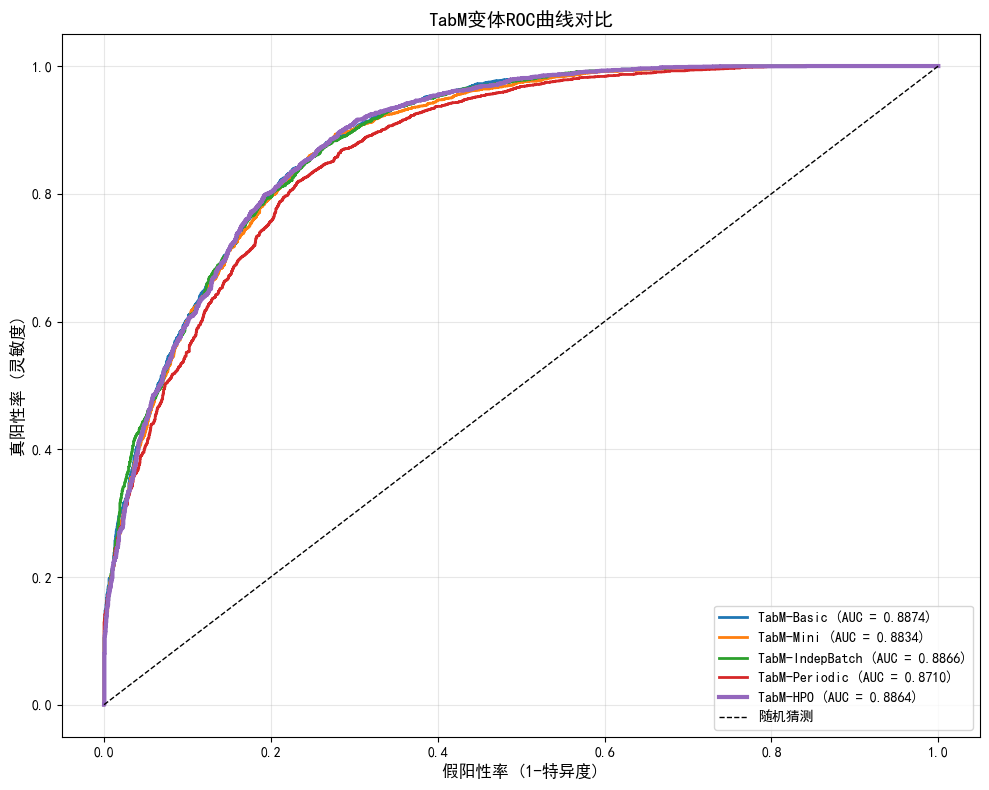

ROC曲线已保存


In [36]:
plt.figure(figsize=(10, 8))

models_info = [
    ("TabM-Basic", metrics_basic["y_proba"], metrics_basic["auc"]),
    ("TabM-Mini", metrics_mini["y_proba"], metrics_mini["auc"]),
    ("TabM-IndepBatch", metrics_indep["y_proba"], metrics_indep["auc"]),
    ("TabM-Periodic", metrics_periodic["y_proba"], metrics_periodic["auc"]),
    ("TabM-HPO", metrics_hpo["y_proba"], metrics_hpo["auc"]),
]

y_val_np = y_validation_binary.values

for model_name, y_proba, auc_score in models_info:
    fpr, tpr, _ = roc_curve(y_val_np, y_proba)
    linewidth = 3 if model_name == "TabM-HPO" else 2
    plt.plot(
        fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})", linewidth=linewidth
    )

plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="随机猜测")
plt.xlabel("假阳性率 (1-特异度)", fontsize=12)
plt.ylabel("真阳性率 (灵敏度)", fontsize=12)
plt.title("TabM变体ROC曲线对比", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("./output/tabm_enhanced/ROC曲线对比.png", dpi=300, bbox_inches="tight")
plt.savefig("./output/tabm_enhanced/ROC曲线对比.pdf", bbox_inches="tight")
plt.show()
print("ROC曲线已保存")

## 17. 选择最佳模型并复制到标准位置

In [37]:
print("=" * 70)
print("选择最佳模型（以F1为标准）")
print("=" * 70)

# 找出最佳模型
all_metrics = {
    "basic": metrics_basic,
    "mini": metrics_mini,
    "indep": metrics_indep,
    "periodic": metrics_periodic,
    "hpo": metrics_hpo,
}

best_model_name = max(all_metrics, key=lambda x: all_metrics[x]["f1"])  # 以F1为标准
best_metrics = all_metrics[best_model_name]

print(f"最佳模型: TabM-{best_model_name}")
print(f"  F1:  {best_metrics['f1']:.4f}")
print(f"  AUC: {best_metrics['auc']:.4f}")

# 复制最佳模型到标准位置
import shutil

src_model = f"./output/tabm_enhanced/models/tabm_{best_model_name}.pt"
dst_model = "./output/models/tabm_best.pt"
shutil.copy(src_model, dst_model)

# 保存预处理器（包含scaler用于标准化）
joblib.dump(
    {
        "imputer": imputer,
        "scaler": scaler,
        "best_model_name": best_model_name,
        "metrics": best_metrics,
    },
    "./output/models/tabm_preprocessors.pkl",
)

print(f"\n最佳模型已复制到: {dst_model}")
print("=" * 70)

选择最佳模型（以F1为标准）
最佳模型: TabM-hpo
  F1:  0.8436
  AUC: 0.8864

最佳模型已复制到: ./output/models/tabm_best.pt
